# Compressive Magnetic Resonance Imaging

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Zeqiang-Lai/Delta-Prox/blob/master/notebooks/csmri.ipynb) 

Magnetic resonance imaging (MRI) is a widely-deployed medical imaging modality for diagnosing and disease monitoring. MRI scanners are prohibitively expensive, and their scanning time directly correlates to the accessibility of MRI scanners to the broader class of patients. Compressed sensing MRI (CS-MRI) accelerates MRI manyfold through subsampling in K-space and computationally recovering the MRI image.


Recovering high-quality images from undersampled MRI data is an ill-posed inverse imaging problem with a forward model that can be mathematically expressed as, 
$$
y = \mathcal{F}_p \left( x \right) + \epsilon, 
$$
where $x \in \mathbb{C}^N$ is the underlying image,  the operator $\mathcal{F}_p : \mathbb{C}^N \rightarrow \mathbb{C}^M$, with $M < N$, denotes the partially-sampled Fourier transform, and $\epsilon \sim \mathcal{N} \left(0, \sigma_n I_M \right)$ is the additive white Gaussian noise. The data-fidelity term, for the MRI reconstruction, is $\mathcal{D} (x) = \frac{1}{2} \| y - \mathcal{F}_p \left(x\right) \|^2$ whose proximal operator is described in [Eksioglu 2016].

With this forward model in hand, ∇-Prox facilitates experimenting with different solvers in only a few lines of code, including: 

1. Plug-and-Play Solver
2. Plug-and-Play Solver with Learned Scheduler
3. Deep Equilibrium Solver
4. Unrolled Solver 

In [1]:
# uncomment the following line to install dprox if your are in online google colab notebook
# !pip install dprox

In [2]:
import torch
from torch.utils.data import DataLoader

from dprox import *
from dprox.utils import *
from dprox.utils.examples.csmri import EvalDataset

### Prepare Data

Let's load some sample data. Since the observation of CS-MRI lies in complex domain, we visualize the magnitude. The initial guess $x_0$ is obtained by performing inverse FFT on the observation $y_0$.

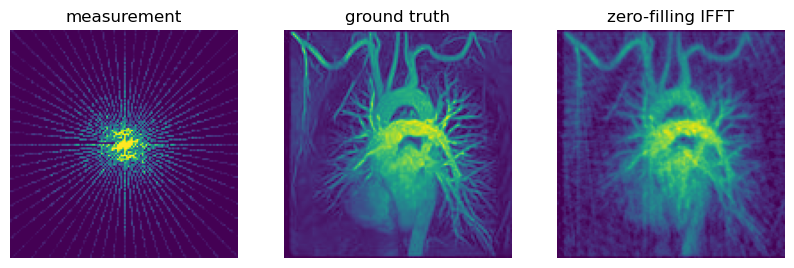

In [3]:
dataset = EvalDataset('sample_data/csmri')
loader = DataLoader(dataset)

batch = next(iter(loader))
y0 = batch['y0']
target = batch['gt']
mask0 = batch['mask']
x0 = batch['x0'].real
y0_vis = outlier_correct((y0.abs()+1).log(), p=0.5)  # for visualization only

imshow(y0_vis, target, x0, gray=False, titles=['measurement', 'ground truth', f'zero-filling IFFT'], off_axis=True)

### Plug-and-Play Solver

In ∇-Prox, we could use ADMM to solve CS-MRI with learned plug-and-play denoising prior using the following lines of code,

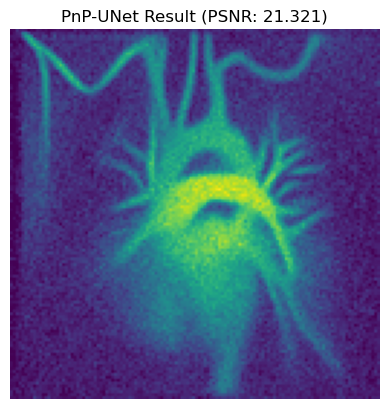

In [4]:
x = Variable()
y = Placeholder()
mask = Placeholder()
data_term = csmri(x, mask, y)
reg_term = deep_prior(x, denoiser='unet')
p = Problem(data_term + reg_term)

y.value = y0
mask.value = mask0
max_iter = 24
rhos, sigmas = log_descent(70, 40, max_iter)
rhos, _ = log_descent(120, 0.1, max_iter)
p.solve(method='admm', x0=x0, rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter)

imshow(x.value.real, titles=[f'PnP-UNet Result (PSNR: {psnr(x.value.real, target):.3f})'], off_axis=True)

**Switch to Different Deep Prior**

We could observe the result is much better than initial guess, but the noise still exists. Let's try some advanced denoiser, such as DRUNet [Zhang et al. 2021].

The result is slightly better, but is still noisy.

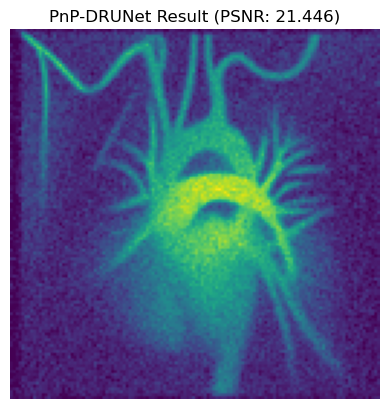

In [5]:
reg_term = deep_prior(x, denoiser='drunet')
p = Problem(data_term + reg_term)
p.solve(method='admm', x0=x0, rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter)

imshow(x.value.real, titles=[f'PnP-DRUNet Result (PSNR: {psnr(x.value.real, target):.3f})'], off_axis=True)

**Switch to Other Algorithms**

Here, we demonstrate that ∇-Prox makes it very easy to write custom algorithm for specific applications.

In the following, we show a variant of ADMM with slightly different computation order, where we perform proximal update first instead of least-square first.

In [6]:
class CustomADMM(ADMM):
    def _iter(self, state, rho, lam):
        x, z, u = state
        x = [x]
        z = z[0]

        for i, fn in enumerate(self.psi_fns):
            x[i] = fn.prox(z - u[i], lam=lam[fn])

        b = [x[i] + u[i] for i in range(len(self.psi_fns))]
        z = self.least_square.solve(b, rho)

        for i, fn in enumerate(self.psi_fns):
            u[i] = u[i] + x[i] - z

        return x[0], [z], u

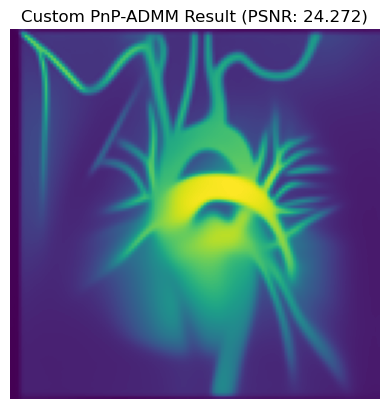

In [7]:
psi_fns, omega_fns = CustomADMM.partition(data_term+reg_term)
solver = CustomADMM(psi_fns, omega_fns)
solver.solve(x0=x0, rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter)

imshow(x.value.real, titles=[f'Custom PnP-ADMM Result (PSNR: {psnr(x.value.real, target):.3f})'], off_axis=True)

 🎉 Oops, the results is much cleaner! However, it might be too smooth though.

### Plug-and-Play Solver with Learned Scheduler

As we can observe from previous results, naive plug-and-play approach works, however, it achieves less pleasant results. This can be largely attributed to the suboptimal hyperparameters we set for ADMM.

To achieve better results, we could utilize the automatic learned parameter scheduler provided by ∇-Prox.
This can be done by simply wrapping existing `solver` in an `AutoTuneSolver`, or using `specalize` utility to perform a specialization.

Now, the `solve` method of the new solver does not require users to provide `rhos` and `lams`, as the hyperparameters are automatically set by internal scheduler. 

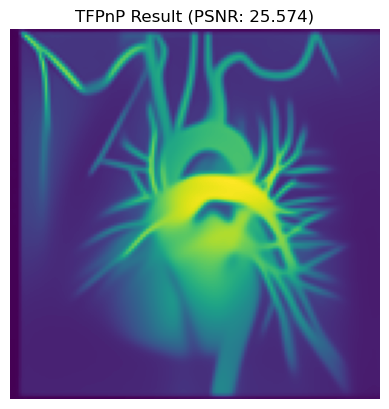

In [8]:
from dprox.algo.tune import *
from dprox.utils.examples.csmri import custom_policy_ob_pack_fn

tf_solver = AutoTuneSolver(solver, policy='resnet', custom_policy_ob_pack_fn=custom_policy_ob_pack_fn)
tf_solver.load(get_path('checkpoints/csmri_tfpnp_unet_custom_admm.pth'))

pred = tf_solver.solve(x0, aux_state=batch).real
imshow(pred, titles=[f'TFPnP Result (PSNR: {psnr(pred, target):.3f})'], off_axis=True)

Though still somewhat smooth, we can see that more details are recovered for now. 🌞

### Deep Equilibrium Solver

Deep Equilibrium (DEQ) solvers approach inverse problems by formulating them as finding the equilibrium point of a certain dynamical system, such as ADMM iterations. Unlike plug-and-play solvers, DEQ solvers conceptually iterate over an infinite number of iterations, which makes them more robust and effective in some cases.

To use it, ∇-Prox provides a class `DEQSolver` that can be used to wrap an existing solver to build a DEQ Solver. Another approach is use `specialize` utility to perform specialization on existing solver. Both approaches generate the same DEQ solver. 

d:\papers\code\optimization\delta-prox\dprox\algo\special\deq_utils\solvers.py:200: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:250.)
  X[:,0], F[:,0] = x0.reshape(bsz, -1), f(x0).reshape(bsz, -1)


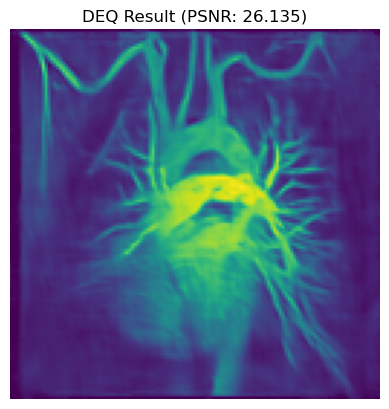

In [9]:
reg_term = deep_prior(x, denoiser='unet')
psi_fns, omega_fns = CustomADMM.partition(data_term+reg_term)
solver = CustomADMM(psi_fns, omega_fns)
deq_solver = DEQSolver(solver, learned_params=True).cuda()
ckpt = torch.load(get_path('checkpoints/csmri_deq_unet.pth'))
ckpt['rhos'] = log_descent(1, 1, max_iter, lam=0.5)
deq_solver.load_state_dict(ckpt['solver'], strict=True)

max_iter = 1
_, sigmas = log_descent(130, 130, max_iter)
pred = deq_solver.solve(x0=x0.cuda(), rhos=rhos, lams={reg_term: sigmas}, max_iter=max_iter).real
imshow(pred, titles=[f'DEQ Result (PSNR: {psnr(pred, target):.3f})'], off_axis=True)

### Unrolled Solver 

Finally, let's try to specialize the solver by fine-tuning the deep prior for the task of CSMRI. This is usually helpful because the deep prior is typically an off-the-shelf image denoiser without knowledge about CSMRI. 

To do so, ∇-Prox provide supports for unrolling the solver iterations for fine-tuning. The training can be achieved by calling `train_unroll`. Here, we simply load the pretrained checkpoint and see what results we could get.

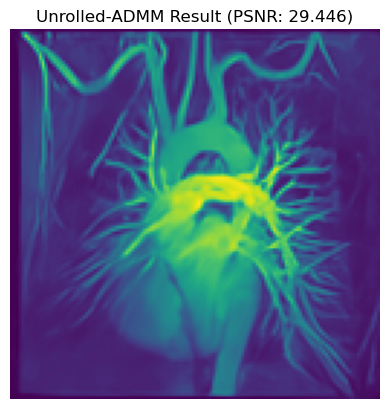

In [10]:
reg_term = deep_prior(x, denoiser='unet')
psi_fns, omega_fns = CustomADMM.partition(data_term+reg_term)
solver = CustomADMM(psi_fns, omega_fns)
unrolled_solver = UnrolledSolver(solver, max_iter=10, shared=True, learned_params=True).cuda()
unrolled_solver.load_state_dict(torch.load(get_path('checkpoints/csmri_unroll_unet_custom_admm.pth')))

pred = unrolled_solver.solve(x0=x0).real
imshow(pred, titles=[f'Unrolled-ADMM Result (PSNR: {psnr(pred, target):.3f})'], off_axis=True)

🧐 oops! Now we get result that outperforms all the previous ones by a large margin on PSNR. 

So far, we have experimented with six different methods for solving this sample problem. The methods we tried include,

| # | Method                                | PSNR |
| - | ------------------------------------- | ---- |
| 1 | Plug-and-play with UNet deep prior    |21.32      |
| 2 | Plug-and-play with DRUNet deep prior  | 21.45     |
| 3 | Plug-and-play with custom ADMM        | 24.27     |
| 4 | Plug-and-play with learned scheduler | 25.57    |
| 5 | Deep equilibrium solver               |  26.14    |
| 6 | Unrolled solver                       |  29.45    |


Though we obtain the decent results after six attempts, we should note that more attempts might be required for other problems. 
Implementing and experimenting all these methods are not an easy task, and it often requires domain expertise on both proximal optimization and deep learning, which is often error-prone and time-consuming. 

With ∇-Prox, users are allowed to specify optimization objective functions of unknowns concisely at a high level, and intelligently compiles the problem into compute and memory efficient differentiable solvers, which make fast prototyping of different methods much easier.

### Reference

[Eksioglu 2016] Ender M Eksioglu. 2016. Decoupled algorithm for MRI reconstruction using nonlocal block matching model: BM3D-MRI. Journal of Mathematical Imaging and Vision 56, 3 (2016), 430–440.

[Zhang et al. 2021]  Kai Zhang, Yawei Li, Wangmeng Zuo, Lei Zhang, Luc Van Gool, and Radu Timofte. 2021. Plug-and-play image restoration with deep denoiser prior. IEEE Transactions on Pattern Analysis and Machine Intelligence (2021).